Following http://edwardlib.org/tutorials/unsupervised and http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/unsupervised.ipynb.

### Set up the system

In [1]:
%matplotlib inline

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import tensorflow        as tf
import edward            as ed
import matplotlib.cm     as cm

from edward.models import Dirichlet, Normal, InverseGamma, ParamMixture, MultivariateNormalDiag, Empirical

### Access the data

In [2]:
df_data = pd.read_csv('https://raw.githubusercontent.com/LEggert/Probabilistic-Programming/master/use_case_clustering/use_case_clustering_data.csv')

In [3]:
df_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df_data.shape

(440, 8)

Let us take two dimensions, e. g. "Milk" and "Detergents Paper".

In [5]:
n = 200  # number of observations
d = 2    # number of dimensions
x_train = df_data[['Milk', 'Detergents_Paper']].astype(np.float32).iloc[:n].values

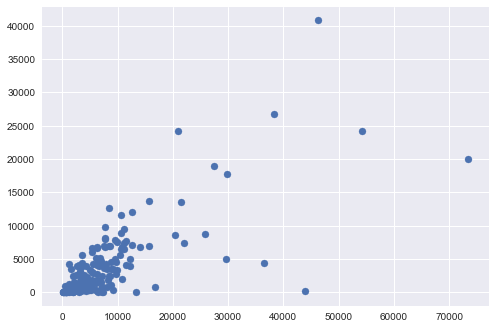

In [6]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

### Specify the model

In [7]:
k       = 2  # number of components
pi      = Dirichlet(tf.ones(k))
mu      = Normal(tf.zeros(d), tf.ones(d), sample_shape=k)
sigmasq = InverseGamma(tf.ones(d), tf.ones(d), sample_shape=k)
x       = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag, sample_shape=n)
z       = x.cat

### Perform inference

Set up empirical random variables to approximate the a-posteriori distributions.

In [8]:
t        = 500  # number of MCMC samples
qpi      = Empirical(tf.Variable(tf.ones([t, k]) / k))
qmu      = Empirical(tf.Variable(tf.zeros([t, k, d])))
qsigmasq = Empirical(tf.Variable(tf.ones([t, k, d])))
qz       = Empirical(tf.Variable(tf.zeros([t, n], dtype=tf.int32)))

Run Gibbs sampling.

In [9]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']

500/500 [100%] ██████████████████████████████ Elapsed: 6s | Acceptance Rate: 1.000


### Evaluate model

In [10]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (n, 100, k, d).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([n, 1, 1, 1]) * mu_sample,
                scale=tf.ones([n, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [n, 1, 1, d]), [1, 100, k, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (n, k).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

Determine cluster assignments.

In [11]:
clusters = tf.argmax(log_liks, 1).eval()

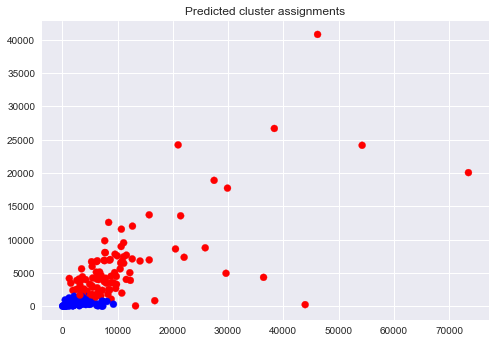

In [12]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.title("Predicted cluster assignments")
plt.show()